In [2]:
#data loading
import os
import datasets
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import timm
import numpy as np
import matplotlib.pyplot as plt

scratch_path = '/scratch/zdz/OLIVES_Dataset_biomarker'

os.makedirs(scratch_path, exist_ok=True)

ds = load_dataset("gOLIVES/OLIVES_Dataset", "biomarker_detection", cache_dir=scratch_path)

print(f"Dataset download to: {scratch_path}")
print(f"train set have {len(ds['train'])} samples")
print(f"test set have {len(ds['test'])} samples")

# transfer dataset to torch
ds = ds.with_format("torch")

# remove Null samples
def is_valid_sample(data_point):
    return (
        data_point['Image'] is not None
        and not torch.isnan(torch.tensor(data_point['BCVA']))
        and not torch.isnan(torch.tensor(data_point['CST']))
        and not any(torch.isnan(torch.tensor(data_point[key])) for key in ['B1'])
    )

ds = ds.filter(is_valid_sample)
print(f"Filtered dataset contains {len(ds['train'])} samples.")
print(f"Filtered dataset contains {len(ds['test'])} samples.")


Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

Dataset download to: /scratch/zdz/OLIVES_Dataset_biomarker
train set have 78822 samples
test set have 3871 samples
Filtered dataset contains 17444 samples.
Filtered dataset contains 3871 samples.


In [6]:
#Functions define    
# Initialize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MultiModalImprovedModel().to(device)

# Dataset definition
class OlivesDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
 
    def __getitem__(self, idx):
        img = self.data[idx]['Image'].float()
        if len(img.shape) == 3 and img.shape[0] == 3:  # If the image has 3 channels
            img = img.mean(dim=0, keepdim=True)  # Convert to single channel
        elif len(img.shape) == 2:  # If the image is already single channel
            img = img.unsqueeze(0)  # Add a channel dimension
 
        if self.transform:
            img = self.transform(img)
 
        clinical = torch.tensor([self.data[idx]['BCVA'], self.data[idx]['CST']], dtype=torch.float32)  # Clinical features
        label = torch.tensor([self.data[idx]['B1'], self.data[idx]['B3'], self.data[idx]['B4'], self.data[idx]['B5']], dtype=torch.float32)  # Labels
 
        return {'Image': img, 'Clinical': clinical, 'Label': label}
 
    def __len__(self):
        return len(self.data)

# Improved multi-modal model
class MultiModalImprovedModel(nn.Module):
 
    def __init__(self, num_classes=4):
        super(MultiModalImprovedModel, self).__init__()
        # Image feature extraction module (EfficientNet)
        self.image_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.image_model.conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  # Adapt input for single-channel images
        self.image_model.classifier = nn.Identity()  # Remove the classifier layer
        image_feature_dim = self.image_model.num_features
        
        # Local feature multi-scale extraction module
        self.local_decoder = nn.Sequential(
            nn.Conv2d(image_feature_dim, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64)
        )
        
        # Global feature processing module
        self.global_decoder = nn.Sequential(
            nn.Linear(image_feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        
        # Clinical feature processing module
        clinical_feature_dim = 32
        self.clinical_fc = nn.Sequential(
            nn.Linear(2, clinical_feature_dim),
            nn.BatchNorm1d(clinical_feature_dim),
            nn.ReLU(),
            nn.Linear(clinical_feature_dim, clinical_feature_dim)
        )
        
        # Dynamic fusion weight
        self.fusion_weight = nn.Parameter(torch.tensor(0.5))
        
        # Cross-modal feature fusion module (attention mechanism + Bi-LSTM)
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=64 + clinical_feature_dim,
            num_heads=4,
            batch_first=True
        )
        self.bi_lstm = nn.LSTM(
            input_size=64 + clinical_feature_dim,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        # Output layer
        self.output_fc = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, images, clinical_features):
        # Extract image features
        image_features = self.image_model(images)  # [batch_size, image_feature_dim]
        
        # Separate global and local features
        local_features = self.local_decoder(image_features.unsqueeze(-1).unsqueeze(-1))  # Local features
        global_features = self.global_decoder(image_features)  # Global features
        
        # Process clinical features
        clinical_features = self.clinical_fc(clinical_features)
        
        # Dynamically weighted fusion of features
        fused_features = self.fusion_weight * local_features + (1 - self.fusion_weight) * global_features
        combined_features = torch.cat([fused_features, clinical_features], dim=1).unsqueeze(1)
        
        # Attention-based fusion
        attended_features, _ = self.cross_attention(combined_features, combined_features, combined_features)
        
        # Bi-LSTM to extract temporal features
        lstm_out, _ = self.bi_lstm(attended_features)
        
        # Output predictions
        outputs = self.output_fc(lstm_out[:, -1, :])
        
        return outputs


# Adaptive multi-task loss function
class MultiTaskLoss(nn.Module):
    def __init__(self, num_tasks):
        super(MultiTaskLoss, self).__init__()
        self.log_vars = nn.Parameter(torch.zeros(num_tasks))
 
    def forward(self, losses):
        total_loss = 0
        for i, loss in enumerate(losses):
            total_loss += torch.exp(-self.log_vars[i]) * loss + self.log_vars[i]
        return total_loss / len(losses)
 
multi_task_loss = MultiTaskLoss(num_tasks=4).to(device)

# Training function
def train_model(model, train_loader, optimizer, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in train_loader:
            images = batch['Image'].to(device)
            clinical = batch['Clinical'].to(device)
            labels = batch['Label'].to(device)
 
            optimizer.zero_grad()
            outputs = model(images, clinical)
            losses = [criterion(outputs[:, i], labels[:, i]) for i in range(labels.shape[1])]
            loss = multi_task_loss(losses)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
 
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")
   
# Function to evaluate the model and plot ROC curves
def evaluate_model_and_plot_roc(model, data_loader, threshold=0.5):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for batch in data_loader:
            images = batch['Image'].to(device)
            clinical = batch['Clinical'].to(device)
            labels = batch['Label'].to(device)

            # Model predictions
            outputs = model(images, clinical)
            probabilities = torch.sigmoid(outputs).cpu().numpy()  # Convert to probabilities

            # Apply threshold to convert probabilities to binary labels
            predictions = (probabilities > threshold).astype(int)

            # Collect true labels, predictions, and probabilities
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predictions)
            all_probabilities.append(probabilities)

    # Convert to NumPy arrays
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)
    all_probabilities = np.vstack(all_probabilities)

    # 1. Calculate F1 Score
    f1_micro = f1_score(all_labels, all_predictions, average='micro')
    f1_macro = f1_score(all_labels, all_predictions, average='macro')
    per_biomarker_f1 = []
    for i in range(all_labels.shape[1]):
        f1 = f1_score(all_labels[:, i], all_predictions[:, i], average='binary')
        per_biomarker_f1.append(f1)

    # Print F1 Scores
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    for i, f1 in enumerate(per_biomarker_f1):
        print(f"F1 Score (Biomarker {i + 1}): {f1:.4f}")

    # 2. Calculate accuracy
    per_biomarker_accuracy = []
    for i in range(all_labels.shape[1]):
        accuracy = accuracy_score(all_labels[:, i], all_predictions[:, i])
        per_biomarker_accuracy.append(accuracy)

    # Print accuracies
    for i, acc in enumerate(per_biomarker_accuracy):
        print(f"Accuracy (Biomarker {i + 1}): {acc:.4f}")

    # 3. Plot ROC curves
    plt.figure(figsize=(10, 8))
    auc_scores = []
    for i in range(all_labels.shape[1]):
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label=f'Biomarker {i + 1} (AUC = {roc_auc:.2f})')

    # Add diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Add legend and labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Biomarkers')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

    # Return evaluation results
    results = {
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "per_biomarker_f1": per_biomarker_f1,
        "per_biomarker_accuracy": per_biomarker_accuracy,
        "auc_scores": auc_scores
    }
    return results

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])



# Create DataLoader
train_dataset = OlivesDataset(ds['train'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = OlivesDataset(ds['test'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [8]:
#Training

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# Train the model
train_model(model, train_loader, optimizer, epochs=20)#set epochs here

# Save model weights
torch.save(model.state_dict(), "multi_modal_model_weights.pth")
print("Model weights saved to multi_modal_model_weights.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/1, Loss: 0.0201
Model weights saved to multi_modal_model_weights.pth


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


F1 Score (Micro): 0.6658
F1 Score (Macro): 0.6037
F1 Score (Biomarker 1): 0.6337
F1 Score (Biomarker 2): 0.7951
F1 Score (Biomarker 3): 0.4830
F1 Score (Biomarker 4): 0.5030
Accuracy (Biomarker 1): 0.7166
Accuracy (Biomarker 2): 0.7641
Accuracy (Biomarker 3): 0.6892
Accuracy (Biomarker 4): 0.9571


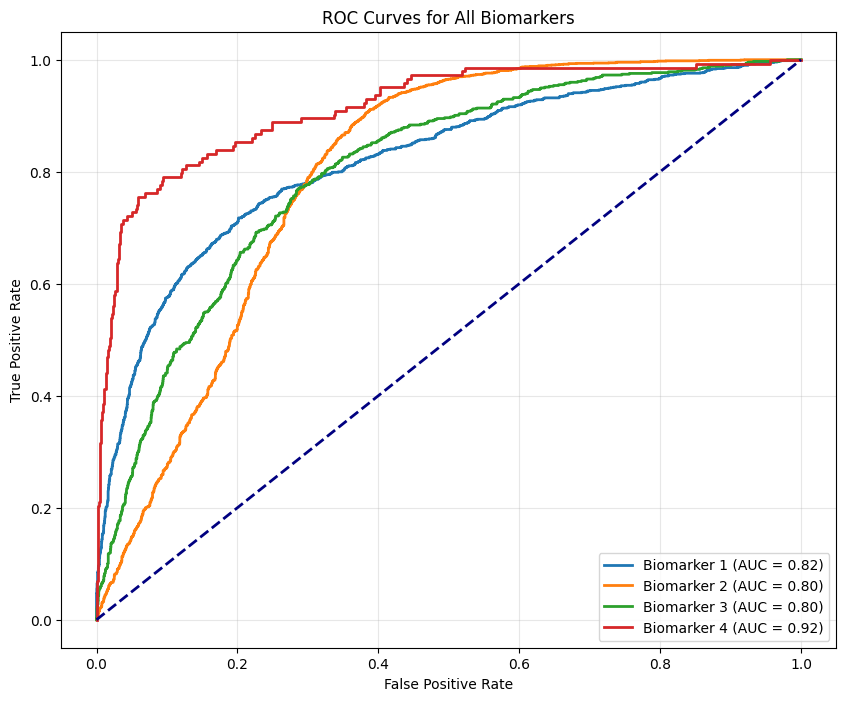

In [7]:
#Training and evaluation
# Initialize the model with existing pth file
model.load_state_dict(torch.load("multi_modal_model_weights.pth"))
model.eval()

# Call the integrated evaluation function
evaluation_results = evaluate_model_and_plot_roc(model, test_loader)
